# Init

In [2]:
# library
suppressMessages(suppressWarnings({
    library(stringr)
    library(Matrix)
    library(jsonlite)
    library(ggplot2)
    library(dplyr)
    library(arrow)
    library(pryr)
    library(data.table)
    library(lubridate)
    library(hms)
}))

# set work_dir and other dirs
work_dir = '/home/yu/OneDrive/NewsReason/local-dev'
data_dir = str_c(work_dir, '/data')
local_wrds = '/home/yu/OneDrive/CloudData/local-wrds'
local_wrds_crsp = str_c(local_wrds, '/crsp')
local_wrds_comp = str_c(local_wrds, '/compustat')
local_wrds_ibes = str_c(local_wrds, '/ibes')
local_wrds_ciq = str_c(local_wrds, '/ciq')
local_wrds_transcript = str_c(local_wrds, '/ciq-transcripts')
local_wrds_finratios = str_c(local_wrds, '/financial-ratios')
local_wrds_yu = str_c(local_wrds, '/yu')
local_wrds_rp = str_c(local_wrds, '/raven-pack')

setwd(work_dir)
cat(str_c('Current working directory: ', getwd(), '\n'))

# default plot size and resolution (4 inch * 6 inch)
options(repr.plot.height=4, repr.plot.width=6, repr.plot.res = 200)

# display more rows and cols
options(repr.matrix.max.cols=500) 


# ---- helpers ----
unpack_reasons <- function(ele, force_reason_type) {
    if (length(ele)==0 | all(is.na(ele))) {
        return(NA)
    } else {
        out = list()
        for (i in 1:nrow(ele)) {
            if (force_reason_type) {
                reason = 'REASON'
            } else reason = str_trim(ele[i, 3])

            out[[i]] = c(ele[i, 1], ele[i, 2], reason)
        }
        out
    }
}

# read jsonl file
# - the jsonl file could be 1) unannotated data, or 2) annotated data downloaded
#   from doccano
read_jsonl <- function(path, force_reason_type=T) {
    # Args:
    #     force_reason_type: If TRUE, all reasons are of type "Reason"; 
    #         If FALSE, return reasons as it is.
    
    con = file(path, open='r')
    out = jsonlite::stream_in(con) %>% as.data.table()
    close(con)

    # ---- get reasons ----
    # (for Batch 1-4)
    if ('entities' %in% names(out)) {
        # parse start/end position
        out = out[, ':='(reasons=lapply(entities, unpack_reasons, force_reason_type))
            ][, ':='(first_reason_start=sapply(reasons, get_first_reason_start),
                     first_reason_end=sapply(reasons, get_first_reason_end),
                     first_reason_type=sapply(reasons, get_first_reason_type))
            ][, ':='(first_reason=str_sub(text, first_reason_start, first_reason_end))
            ][, ':='(entities=NULL)]
    # (for Batch-5)
    } else if ('label' %in% names(out)) {
        # parse start/end position
        out = out[, ':='(reasons=lapply(label, unpack_reasons, force_reason_type))
            ][, ':='(first_reason_start=sapply(reasons, get_first_reason_start),
                     first_reason_end=sapply(reasons, get_first_reason_end),
                     first_reason_type=sapply(reasons, get_first_reason_type))
            ][, ':='(first_reason=str_sub(data, first_reason_start, first_reason_end))
            ][, ':='(label=NULL)]
    }
    out[]
}

# get the first reason start position
get_first_reason_start <- function(ele) {
    if (length(ele)==0) {
        return(NA)
    } else as.integer(ele[[1]][1])
}

# get the first reason end position
get_first_reason_end <- function(ele) {
    if (length(ele)==0) {
        return(NA)
    } else as.integer(ele[[1]][2])
}

# get the first reason type
get_first_reason_type <- function(ele) {
    if (length(ele)==0) {
        return(NA)
    } else str_trim(ele[[1]][3])
}

Current working directory: /home/yu/OneDrive/NewsReason/local-dev


# (pilot) Batch-1

## 1-unannotated

In [3]:
# Notes:
# - The code used to created the unannotated data is LOST
unannotated = read_jsonl(str_c(data_dir, '/annotation/batch-1/1-unannotated/unannotated.jsonl'))

 Imported 100 records. Simplifying...


## 2-annotated

In [4]:
# "annotated-raw" from j and yu
annotated_raw_yu = read_jsonl(str_c(data_dir, '/annotation/batch-1/2-annotated/annotated-raw-yu.jsonl'))
annotated_raw_j = read_jsonl(str_c(data_dir, '/annotation/batch-1/2-annotated/annotated-raw-j.jsonl'))

# "annotated-agreed"
annotated_agreed = read_jsonl('/home/yu/OneDrive/NewsReason/local-dev/data/annotation/batch-1/2-annotated/annotated-agreed.jsonl')

# load unannotated data
unannotated = read_jsonl(str_c(data_dir, '/annotation/batch-1/1-unannotated/unannotated.jsonl'))

# merge "annotated-agreed" and "unannotated"
# - we need to merge with "unannotated" because "annotated-agreed" only contains obs
#   that have annotation, i.e., if one headline has no reason, it will not be included.
annotated_agreed_full = annotated_agreed[
      unannotated, 
      on=.(text, entity, date, sentiment, type)
    ][order(entity, date)
    ][, .(text, reasons, first_reason)
    ]
    
sv(annotated_agreed_full, folder=str_c(data_dir, '/annotation/batch-1/2-annotated'))

sprintf('N obs: %s', nrow(annotated_agreed_full))

 Imported 40 records. Simplifying...
 Imported 44 records. Simplifying...
 Imported 62 records. Simplifying...
 Imported 100 records. Simplifying...
"annotated_agreed_full" saved as "annotated_agreed_full.feather" (10.5 KB) (0.01 secs, 2022-09-06 05:52:18)


[1] "N obs: 100"

# (pilot) Batch-2

## 1-unannotated

In [5]:
# # ---- create samples ----
# # load price data
# ld(rpa_stock_price_unique_headline, 'rpa_unique_headline')

# # clean text
# set.seed(42)
# unannotated = rpa_unique_headline[sample(.N, 500)
#     ][, ':='(headline=str_replace(headline, '^" ', ''))
#     ][, .(text=headline, entity=entity_name, date=date, sentiment=event_sentiment_score, type=sub_type, gvkey)]

# # write to jsonl
# library(jsonlite)
# con_out = file('./data/annotation/batch-2/unannotated.jsonl', open='wb')
# stream_out(unannotated, con_out)
# close(con_out)

## 2-annotated

In [6]:
# load "annotated-raw" from j and yu
annotated_raw_j = read_jsonl(str_c(data_dir, '/annotation/batch-2/2-annotated/annotated-raw-j.jsonl'))
annotated_raw_yu = read_jsonl(str_c(data_dir, '/annotation/batch-2/2-annotated/annotated-raw-yu.jsonl'))

# load "annotated-agreed"
annotated_agreed = read_jsonl('/home/yu/OneDrive/NewsReason/local-dev/data/annotation/batch-2/2-annotated/annotated-agreed.jsonl')

# load unannotated data
unannotated = read_jsonl(str_c(data_dir, '/annotation/batch-2/1-unannotated/unannotated.jsonl'))

# merge "annotated-agreed" and "unannotated"
# - we need to merge with "unannotated" because "annotated-agreed" only contains obs
#   that have annotation, i.e., if one headline has no reason, it will not be included.
annotated_agreed_full = annotated_agreed[
      unannotated, 
      on=.(text, entity, date, sentiment, type)
    ][order(entity, date)
    ][, .(text, reasons, first_reason)
    ]

sv(annotated_agreed_full, folder=str_c(data_dir, '/annotation/batch-2/2-annotated'))

sprintf('N obs: %s', nrow(annotated_agreed_full))

 Imported 276 records. Simplifying...
 Imported 305 records. Simplifying...
 Imported 301 records. Simplifying...
 Imported 500 records. Simplifying...
"annotated_agreed_full" saved as "annotated_agreed_full.feather" (37.8 KB) (0.01 secs, 2022-09-06 05:52:18)


[1] "N obs: 500"

# Batch-3 (600 headlines)

> [!Summary] What we did in Batch-3
> - Merge Batch-1 and Batch-2, yielding 600 headlines.
> 
> - Remove the annotated reasons in the two batches.
>
> - **Re-annotate** the 600 headlines with the finalized rules.

## 1-unannotated

- The code used for creating the "unannotated" dataset is LOST. So I can't reproduce.
- Instead, I used the checkpointed "unannotated" dataset.

In [7]:
unannotated = read_jsonl(str_c(data_dir, '/annotation/batch-3/1-unannotated/unannotated.jsonl'))

 Imported 600 records. Simplifying...


## 2-annotated

In [8]:
# load unannotated
unannotated = read_jsonl('./data/annotation/batch-3/1-unannotated/unannotated.jsonl')

# load annotated_agreed
annotated_agreed = read_jsonl(
    './data/annotation/batch-3/2-annotated/annotated-agreed.jsonl',
    force_reason_type=F)

# merge "annotated-agreed" and "unannotated"
# - we need to merge with "unannotated" because "annotated-agreed" only contains obs
#   that have annotation, i.e., if one headline has no reason, it will not be included.
annotated_agreed_full = annotated_agreed[, .(text, reasons, first_reason, first_reason_type, first_reason_start, first_reason_end)
    ][unannotated[, .(text)], on=.(text)]

sv(annotated_agreed_full, folder='./data/annotation/batch-3/2-annotated')

 Imported 600 records. Simplifying...
 Imported 352 records. Simplifying...
"annotated_agreed_full" saved as "annotated_agreed_full.feather" (52.6 KB) (0 secs, 2022-09-06 05:52:19)


# Batch-4 (600 headlines, balanced)

## 1-unannotated

See the Obisidian notes or how the unannotated data is created in Batch-4.

## 2-annotated

In [58]:
# load batch-4 results
annotated_agreed_batch4 = read_jsonl(
    './data/annotation/batch-4/2-annotated/annotated-agreed.jsonl',
    force_reason_type=F)[!is.na(first_reason_type)]
unannotated_batch4 = read_jsonl('./data/annotation/batch-4/1-unannotated/unannotated.jsonl')

# merge "annotated-agreed" and "unannotated"
# - we need to merge with "unannotated" because "annotated-agreed" only contains obs
#   that have annotation, i.e., if one headline has no reason, it will not be included.
annotated_agreed_full_batch4 = annotated_agreed_batch4[, .(text, reasons, first_reason, first_reason_type, first_reason_start, first_reason_end)
    ][unannotated_batch4[, .(text)], on=.(text)]

sv(annotated_agreed_full_batch4, folder='./data/annotation/batch-4/2-annotated')

# load batch-3 results
annotated_agreed_full_batch3 = ld('annotated_agreed_full', folder='./data/annotation/batch-3/2-annotated')
annotated_agreed_full_batch3[, ':='(reasons=as.list(reasons))]

# merge batch-3 and batch-4
annotated_agreed_full_batch3_4 = rbindlist(list(annotated_agreed_full_batch3, annotated_agreed_full_batch4), use.names=T)
annotated_agreed_full_batch3_4 = annotated_agreed_full_batch3_4[
      is.na(first_reason_type), 
      ':='(first_reason_type='[NONE]', first_reason='[NONE]')]

# 1) add "coarse-level" of reasons
# 2) add "reason_type_id" (pytorch only accept int as label)
convert_reason_to_coarse <- function(reasons) {
    # Args:
    #    reasons: reasons of ONE headline
    
    to_coarse <- function(reason) {
        # Args:
        #     reason: a reason of ONE headline
        reason[[3]] = str_replace(reason[[3]], ' \\s*\\([^\\)]+\\)', '') %>% str_trim()   
        reason
    }

    lapply(reasons, to_coarse)
}

annotated_agreed_full_batch3_4 = annotated_agreed_full_batch3_4[, 
    # add "coarse-level" of first_reasons
      ':='(first_reason_type_coarse=str_replace(first_reason_type, ' \\s*\\([^\\)]+\\)', '') %>% str_trim(),
           reasons_coarse=lapply(reasons, convert_reason_to_coarse)),
    ][,
    # add reason_type_id
    # we minus 1 because label in pytorch starts from 0
      ':='(first_reason_type_id=as.integer(factor(first_reason_type, levels=unique(first_reason_type)))-1L,
           first_reason_type_coarse_id=as.integer(factor(first_reason_type_coarse, levels=unique(first_reason_type_coarse)))-1L)]

# shuffle dataset so that we don't need to shuffle in pytorch
set.seed(79)
annotated_agreed_full_batch3_4 = annotated_agreed_full_batch3_4[sample(1:nrow(annotated_agreed_full_batch3_4))]

# save annotated_agreed_full_batch3_4
annotated_agreed_full_batch3_4[, ':='(reasons=lapply(reasons, as.list))]
sv(annotated_agreed_full_batch3_4, folder='./data/annotation/batch-4/2-annotated')

 Imported 515 records. Simplifying...
 Imported 600 records. Simplifying...
"annotated_agreed_full_batch4" saved as "annotated_agreed_full_batch4.feather" (69.5 KB) (0 secs, 2022-09-16 00:40:05)
"annotated_agreed_full.feather" (52.6 KB) loaded (0.01 secs) (2022-09-16 12:40 AM)
"annotated_agreed_full_batch3_4" saved as "annotated_agreed_full_batch3_4.feather" (163.3 KB) (0 secs, 2022-09-16 00:40:05)


In [3]:
tx = ld('annotated_agreed_full_batch3_4', folder='./data/annotation/batch-4/2-annotated')
tx[str_detect(text, 'Thor Shares Fall')]

"annotated_agreed_full_batch3_4.feather" (163.3 KB) loaded (0.03 secs) (2022-09-23 6:32 PM)


text,reasons,first_reason,first_reason_type,first_reason_start,first_reason_end,first_reason_type_coarse,reasons_coarse,first_reason_type_id,first_reason_type_coarse_id
<chr>,<list<list<character>>>,<chr>,<chr>,<int>,<int>,<chr>,<list<list<character>>>,<int>,<int>
Thor Shares Fall As Company Sees 'headwinds' From Steel Tariffs -- MarketWatch,"20 , 63 , External Shock (Policy)",Company Sees 'headwinds' From Steel Tariffs,External Shock (Policy),20,63,External Shock,"20 , 63 , External Shock",18,8


## 3-post-analysis

### "training size" vs. "accuracy"

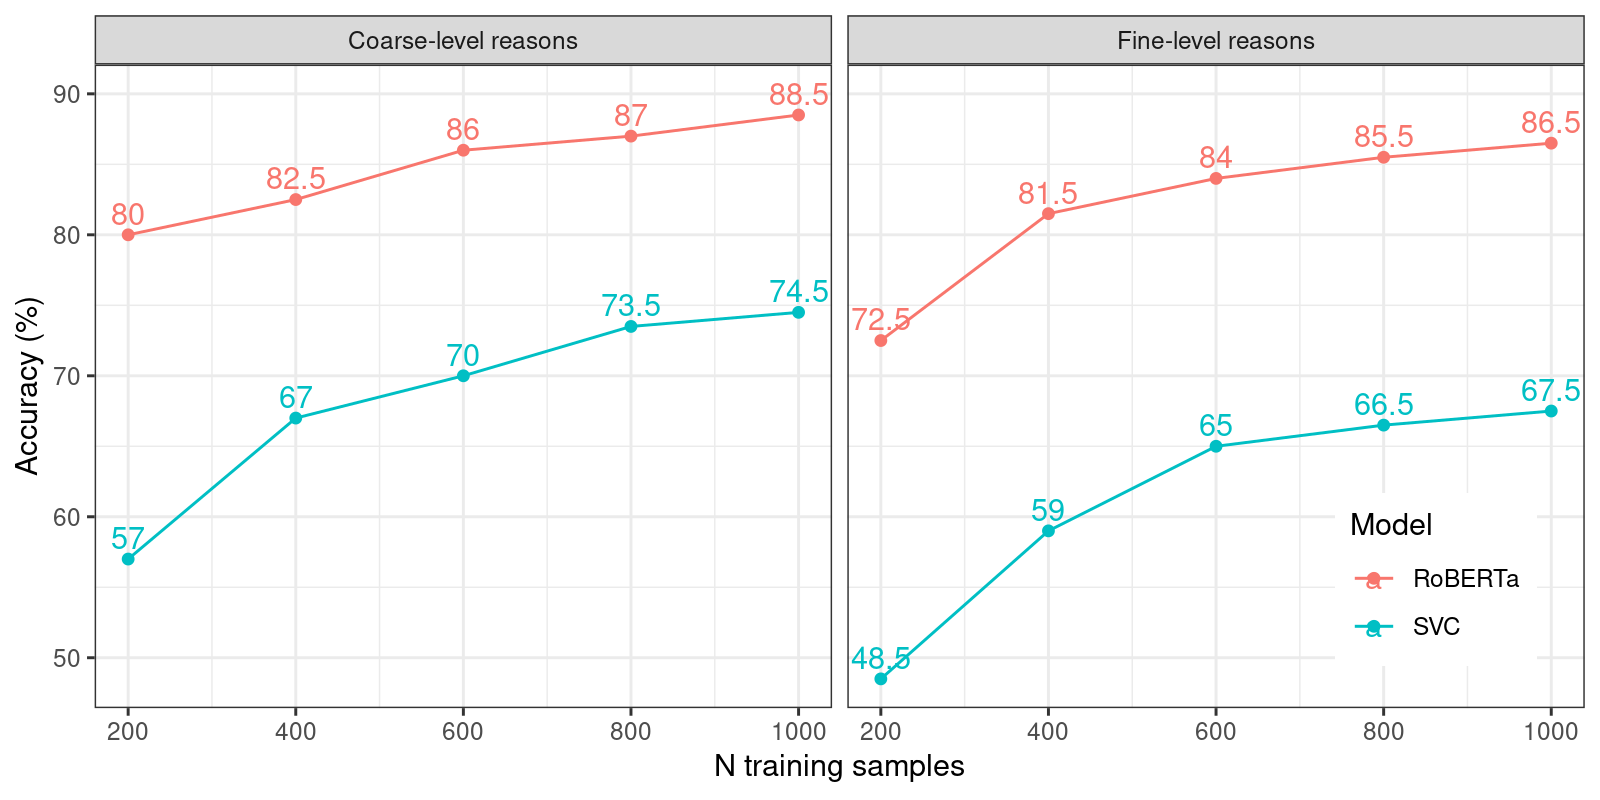

In [22]:
# plot "training size" vs "accuracy"

data_fine = data.table(
    size=c(200, 400, 600, 800, 1000),
    bert=c(53.5, 64.5, 72.5, 77.5, 78.5),
    roberta=c(72.5, 81.5, 84, 85.5, 86.5),
    svc=c(48.5, 59, 65, 66.5, 67.5),
    granularity='Fine-level reasons')

data_coarse = data.table(
    size=c(200, 400, 600, 800, 1000),
    bert=c(60, 74, 78.5, 82, 85.5),
    roberta=c(80, 82.5, 86, 87, 88.5),
    svc=c(57, 67, 70, 73.5, 74.5),
    granularity='Coarse-level reasons')

# select data
data_fine = melt(data_fine, id.vars=c('size', 'granularity'), variable.name='model', value.name='accuracy')
data_coarse = melt(data_coarse, id.vars=c('size', 'granularity'), variable.name='model', value.name='accuracy')
data = rbindlist(list(data_fine, data_coarse))
data = data[, ':='(model=factor(model, labels=c('BERT', 'RoBERTa', 'SVC')))]

options(repr.plot.height=4, repr.plot.width=8, repr.plot.res = 200)
data[model!='BERT'] %>% 
    ggplot(aes(x=size, y=accuracy, label=accuracy, color=model)) +
    geom_line() +
    geom_point() +
    geom_text(nudge_y=1.5) +
    xlab('N training samples') +
    ylab('Accuracy (%)') +
    facet_grid(~ granularity) +
    scale_color_discrete('Model') +
    theme_bw() +
    theme(legend.position=c(0.9, 0.2))
options(repr.plot.height=4, repr.plot.width=6, repr.plot.res = 200)


# Batch-5

## 1-unannotated

**How we create the `unannotated.jsonl` file?**
1. Select all the headlines that are between year [2000, 2020] and follow the below critera, yielding `headlines`.

2. From `headlines`, ramdomly sample 500 headlines, yielding `unannotated.jsonl`.

In [32]:
# read from local_wrds_rp
headlines = open_dataset(
    str_c(local_wrds_rp, '/rpa_full_equities'),
    format='feather'
    ) %>% 
    filter(topic=='business' & group=='stock-prices' &
           relevance>=90 & country_code=='US' & !is.na(event_relevance) & 
           event_relevance==100 & sub_type %in% c('gain', 'loss')) %>%
    select(headline, entity_name, sub_type) %>%
    collect() %>%
    setDT()

# headline must be unique
headlines = headlines %>% unique(by='headline')

In [34]:
# create unpredicted
set.seed(42)
unannotated = headlines[sample(1:nrow(headlines), 500), .(text=headline, entity_name)]
unannotated[1]

# write to json so that doccano can read
library(jsonlite)

con_out = file('/home/yu/OneDrive/NewsReason/local-dev/data/annotation/batch-5/1-unannotated/unannotated.jsonl', open='wb')
stream_out(unannotated, con_out)

close(con_out)

text,entity_name
<chr>,<chr>
PepsiCo Stock Falls 3%,PepsiCo Inc.


Complete! Processed total of 500 rows.


## 2-annotated

In [12]:
# load batch-5 results
annotated_raw_yu = read_jsonl(
    './data/annotation/batch-5/2-annotated/annotated-raw-yu.jsonl',
    force_reason_type=F)[!is.na(first_reason_type)]
unannotated_batch5 = read_jsonl('./data/annotation/batch-5/1-unannotated/unannotated.jsonl')

annotated_agreed_full_batch5 = annotated_raw_yu[, .(text=data, reasons, first_reason, first_reason_type, first_reason_start, first_reason_end)
    ][unannotated_batch5[, .(text)], on=.(text)
    ][is.na(first_reason_type), 
      ':='(first_reason_type='[NONE]', first_reason='[NONE]')]

# load batch3_4
annotated_agreed_full_batch3_4 = ld('annotated_agreed_full_batch3_4', folder='./data/annotation/batch-4/2-annotated')
annotated_agreed_full_batch3_4[, ':='(reasons=as.list(reasons))]

# merge batch-5 with batch3_4, exporting batch3_4_5
annotated_agreed_full_batch3_4_5 = rbindlist(list(annotated_agreed_full_batch3_4, annotated_agreed_full_batch5), use.names=T, fill=T)

# 1) add "coarse-level" of first_reasons
# 2) # add "reason_type_id" (pytorch only accept int as label)
convert_reason_to_coarse <- function(reasons) {
    # Args:
    #    reasons: reasons of ONE headline
    
    to_coarse <- function(reason) {
        # Args:
        #     reason: a reason of ONE headline
        reason[[3]] = str_replace(reason[[3]], ' \\s*\\([^\\)]+\\)', '') %>% str_trim()   
        reason
    }

    lapply(reasons, to_coarse)
}

annotated_agreed_full_batch3_4_5 = annotated_agreed_full_batch3_4_5[, 
    # add "coarse-level" of first_reasons
      ':='(first_reason_type_coarse=str_replace(first_reason_type, ' \\s*\\([^\\)]+\\)', '') %>% str_trim(),
           reasons_coarse=lapply(reasons, convert_reason_to_coarse)),
    ][,
    # add reason_type_id
    # we minus 1 because label in pytorch starts from 0
      ':='(first_reason_type_id=as.integer(factor(first_reason_type, levels=unique(first_reason_type)))-1L,
           first_reason_type_coarse_id=as.integer(factor(first_reason_type_coarse, levels=unique(first_reason_type_coarse)))-1L)]


# export annotated_agreed_full_batch3_4_5
annotated_agreed_full_batch3_4_5[, ':='(reasons=lapply(reasons, as.list))]
sv(annotated_agreed_full_batch3_4_5, folder='./data/annotation/batch-5/2-annotated')

 Imported 301 records. Simplifying...
 Imported 500 records. Simplifying...
"annotated_agreed_full_batch3_4.feather" (163.3 KB) loaded (0.02 secs) (2022-09-25 4:57 AM)
"annotated_agreed_full_batch3_4_5" saved as "annotated_agreed_full_batch3_4_5.feather" (218.9 KB) (0.01 secs, 2022-09-25 04:57:15)
